In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

Frame the Problem and Look at the Big Picture
=====================================

1. **Define the objective in business terms:** We have been hired by Magic Films for their new streaming service which provides access to a wide variety of movies. 
2. **How will your solution be used?** They want to eventually know what movies should be displayed and promoted on the homepage to attract users based on written reviews from viewers as well as what movies to remove from the website to save money on licensing fees.
3. **What solutions are in place?** For certain businesses such as the restaurant business, they try and identify certain keywords in reviews to find out what they are doing well and their customers like and what they can improve on.
4. **How should you frame this problem?** This is a supervised binary classification problem. Based on words and how they are used in a review we want to determine whether the review was `Positive` or `Negative`.
5. **How should performance be measured? Is the performance measure aligned with the business objective?** Because we are not to identify as many positives as we can by risking false positives and we are not trying to identify all the negatives we can, we believe we should use F1 score to find a middle ground. We want to reduce false positives and false negatives as equally as possible.
6. **What would be the minimum performance needed to reach the business objective?** We would like to get our score as close to 1.0 as possible. A goal is to get at least .85 or better.
7. **What are comparable problems? Can you reuse experience or tools?** We have had multi-classification experience with the MNIST data set for trying to decide what a number a written digit or what article of clothing something is. More importantly, we previously created a binary-classification model that would try to predict whether there would be an early spring or not. We would not be able to directly reuse this model in particular because we are trying to identify words within a review to determine if the review was positive or not.
8. **Is human expertise available?** We do not have anyone readily available but we are advised on the Readme to contact Andrew Maas, the organizer of the dataset, with any questions. We can also try and contact the user who uploaded the dataset to Kaggle.
9. **How would you solve the problem manually?** The manual approach would to be to parse up the reviews and try and filter out words with negative or positive connotations in order to decide whether a review is positive or negative. This could be a problem with sarcastic reviews and reviews with spelling errors or slang.
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** We are assuming that the data set is all primarily english and has no spelling mistakes or errors in the reviews.

In [75]:
# Functions for loading and splitting data
def load_data(data):
    """Loads a dataset"""
    return pd.read_csv(data)


def split_labels(data, label_feature):
    """
    Split the given column of of the data, returning the full data set (without that
    feature) and the split off feature.
    """
    return data.drop(columns=label_feature), data[label_feature]

Get the Data
==========

1. **List the data you need and how much you need:** We have a dataset of IMDB movie reviews containing a combniation of positive and negative reviews for movies.
2. **Find and document where you can get that data:** We got the data from: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download
3. **Get access authorizations**: No authorization needed, the data is free to access on Kaggle.
4. **Create a workspace**: This notebook.
5. **Get the data**: Downloaded from Kaggle.
6. **Convert the data to a format you can easily manipulate**: Already in CSV files so easy to use.
7. **Ensure sensitive information is deleted or protected**: Data contains no sensitive information.
8. **Check the size and type of data (time series, geographical, …)**: This categorical data set contains reviews written in text as well as a binary attribute indicating whether the review was positive or not. It contains 50,000 unique values.

In [76]:
data = load_data('imdb_data.csv')

In [77]:
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [78]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [149]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [150]:
positives = train_set[train_set['sentiment']=='positive'].reset_index()
negatives = train_set[train_set['sentiment']=='negative'].reset_index()
len(positives), len(negatives)

(19961, 20039)

About half of the reviews in the training set are positive and the other half is negative, so both types are about equally represented. And it is also nice to know there are not any missing values in the dataset, which is important with just two features.

In [151]:
positives.head(10)

,index,review,sentiment
0,45278,A touching love story reminiscent of In the M...,positive
1,30219,The people who are bad-mouthing this film are ...,positive
2,14290,I own the miniseries on DVD because I love thi...,positive
3,24755,"ELVIRA, MISTRESS OF THE DARK (1988)<br /><br /...",positive
4,48038,"Considering all the teen films like ""the Break...",positive
5,30239,The recent history of Hollywood remakes of gho...,positive
6,7195,While I had wanted to se this film since the f...,positive
7,3579,Star Trek: Hidden Frontier is a long-running i...,positive
8,34095,"The romance of the movie, which is also its ma...",positive
9,10441,Viewed this the other night on cable on-demand...,positive


Below is a positive review, giving us an idea of what this kind of review will look like.

In [152]:
positives['review'][42]

"'A Tale of Two Sisters', or 'Janghwa, Hongryeon', is a true masterpiece. Brilliant psychological thriller, heart-wrenching drama, and gripping horror all wrapped up in one beautifully orchestrated package. From the intricate plot, to the beautiful cinematography, to the absolutely perfect casting, every aspect of this film is extraordinary.<br /><br />For fear of revealing too much concerning the plot, I will just say it is very satisfying. While it may appear to be a little difficult to understand at first, it does a good job of explaining things in the end. And whether you prefer psychological thriller, drama, or horror, I promise you will not be disappointed.<br /><br />From a technical standpoint, its nearly flawless. The set, the cinematography, lighting, and especially the soundtrack, all are captivating. The waltz seemed an odd choice at first, but proved to be an ingenious choice.<br /><br />As for the casting, we're talking absolute perfection. I'm Su-jeong is totally convinc

Below is a negative review, giving us an idea of what this kind of review will look like.
It should be noted that there appear to be `HTML` elements peppered in some of the positive and negative reviews. In this example we see a `<br />` tag.

In [153]:
negatives['review'][13]

"Detective Dave Robicheaux is trying to link the murder of a local hooker to New Orleans mobster Julie Balboni. But during his investigation Robicheaux is led into a series of surreal encounters with a troop of Confederate soldiers??, What a awful plot and it was worser than i had expected. it was real slow and had minimal skill in the acting i could not watch through it it was waste of my time. Another FLOP, i would give it under 1 if i could please people don't waste your time its 1:42m of wast-full time. Actor Elrod Sykes and his girlfriend driving under the influence. As Dave takes Elod to the station the actor tells Dave he found some skeletal remains while on the set of a movie he is filming"

To begin breaking down reviews and what words might entail a negative or positive review we might want to try and see what words are most popularly used...

In [154]:
pd.Series(' '.join(positives['review']).lower().split()).value_counts()[:100]

the      261195
and      136798
a        128325
of       120341
to       103644
          ...  
two        5171
don't      5018
being      4992
made       4986
never      4926
Length: 100, dtype: int64

But as expected, this approach will result in finding a lot of the words will be prepositions, determiners, conjuctions or very basic words found in speech. What might be more helpful is identifying key phrases.

We could try creating a new feature such as review length and see if there is any interesting patterns for negative and postitive review lengths. This may not be extremely helpful because we want to know the sentiment of a review based on its contents but with 2 features creating new ones could be useful.

In [155]:
positives['review_len'] = positives['review'].str.len()
len(positives['review'][0]), positives['review_len'][0]

(502, 502)

In [156]:
negatives['review_len'] = negatives['review'].str.len()
len(negatives['review'][0]), negatives['review_len'][0]

(2328, 2328)

In [157]:
positives.describe()

,index,review_len
count,19961.000000,19961.000000
mean,25153.452182,1325.440860
std,14421.388610,1037.134151
min,0.000000,81.000000
25%,12688.000000,691.000000
50%,25128.000000,968.000000
75%,37694.000000,1614.000000
max,49995.000000,13704.000000


In [158]:
negatives.describe()

,index,review_len
count,20039.000000,20039.000000
mean,24929.297370,1291.453067
std,14460.407721,943.250004
min,3.000000,32.000000
25%,12323.500000,705.000000
50%,24887.000000,971.000000
75%,37438.000000,1565.500000
max,49999.000000,8969.000000


Unfortunately there does not seem like any apparent major differences between the two, but it looks like positive reviews are longer on average.

<AxesSubplot:>

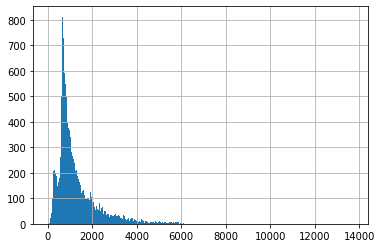

In [159]:
lengths = pd.concat([positives, negatives], axis=0)['review_len']
lengths.hist(bins=1000)

This could be improved with a log transformation. Also its seems that someone wrote a particularly lengthy review.

<AxesSubplot:>

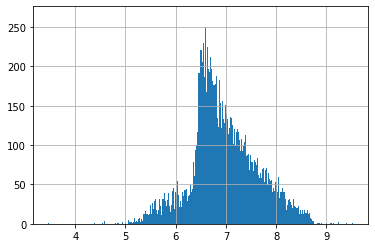

In [160]:
np.log(lengths).hist(bins=1000)

This could be a helpful metric but what we truly want is a way to detect the sentiment in reviews based off the phrases in them.

Prepare the Data
====
1. **Data cleaning:** Fix/remove outliers (optional); We might possibly have to remove really long reviews? But that might not be necessary for evaluating sentiment.
2. **Feature selection** (optional): Drop attributes that provide no useful information for the task
3. **Feature engineering, where appropriate:** Discretize continuous features; Decompose features (categorical, date/time, ...), Add promising transformations of features (log(𝑥𝑥), √𝑥𝑥, 𝑥𝑥2, ...); Aggregate features into promising new features
4. **Feature scaling:** standardize or normalize features